### Imports

In [1]:
# Not sure if I'll need every single one of these imports. I'll do some cleaning afterwards.
import os
import pandas as pd
import numpy as np
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

c:\Users\Palmg\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Loading the data and preparation

In this section we will load our images, transform images into PyTorch tensors and Standardize the pixel values.

For standardization we need Mean and Std. These were calculated in the other notebook: mean_and_std.ipynb

* Computed Mean: tensor([0.4737, 0.4721, 0.3989])
* Computed Std: tensor([0.2029, 0.2014, 0.2066])

In [2]:
mean = [0.4737, 0.4721, 0.3989]
std = [0.2029, 0.2014, 0.2066]

Our transformations

In [3]:
transform = transforms.Compose([
  # Images to PyTorch Tensors
  transforms.ToTensor(),
  # Standardization, usually leads to faster and better training (gradient properties)
  transforms.Normalize(mean, std)
])

Datasets

In [4]:
# Load data from folders, apply our transforms
train_data = datasets.ImageFolder('./data/train', transform=transform)
validation_data = datasets.ImageFolder('./data/valid', transform=transform)
test_data = datasets.ImageFolder('./data/test', transform=transform)

In [5]:
# Print some stats for each
print(f"Training - {len(train_data)} images with {len(train_data.classes)} classes")
print(f"Validation - {len(validation_data)} images with {len(validation_data.classes)} classes")
print(f"Test - {len(test_data)} images with {len(test_data.classes)} classes")

Training - 29274 images with 184 classes
Validation - 920 images with 184 classes
Test - 920 images with 184 classes


In [6]:
# Made a quick CSV that only has labels and corresponding class_ids
birds_df = pd.read_csv('./data/classids_to_labels.csv')
# Use this dataframe to make a dictionary for easy access
# First we set class id into index, then we only have 1 column left which is the labels
# to_dict() converts our selected 'labels' into a dictionary indexed by class id
birds_dict = birds_df.set_index('class id')['labels'].to_dict()


Dataloaders, automating the process of loading batches of data

In [7]:
batch_size = 64

# 64 batch size and add some shuffle because our data is alphabetically ordered
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [8]:
# Check that our X and y are correct shapes
for X, y in train_loader:
    print(f"Shape of X [batch_size, channels, height, width]: {X.shape}")
    print(f"Shape of y [label(int)]: {y.shape}")
    break

Shape of X [batch_size, channels, height, width]: torch.Size([64, 3, 224, 224])
Shape of y [label(int)]: torch.Size([64])


### Let's take a look

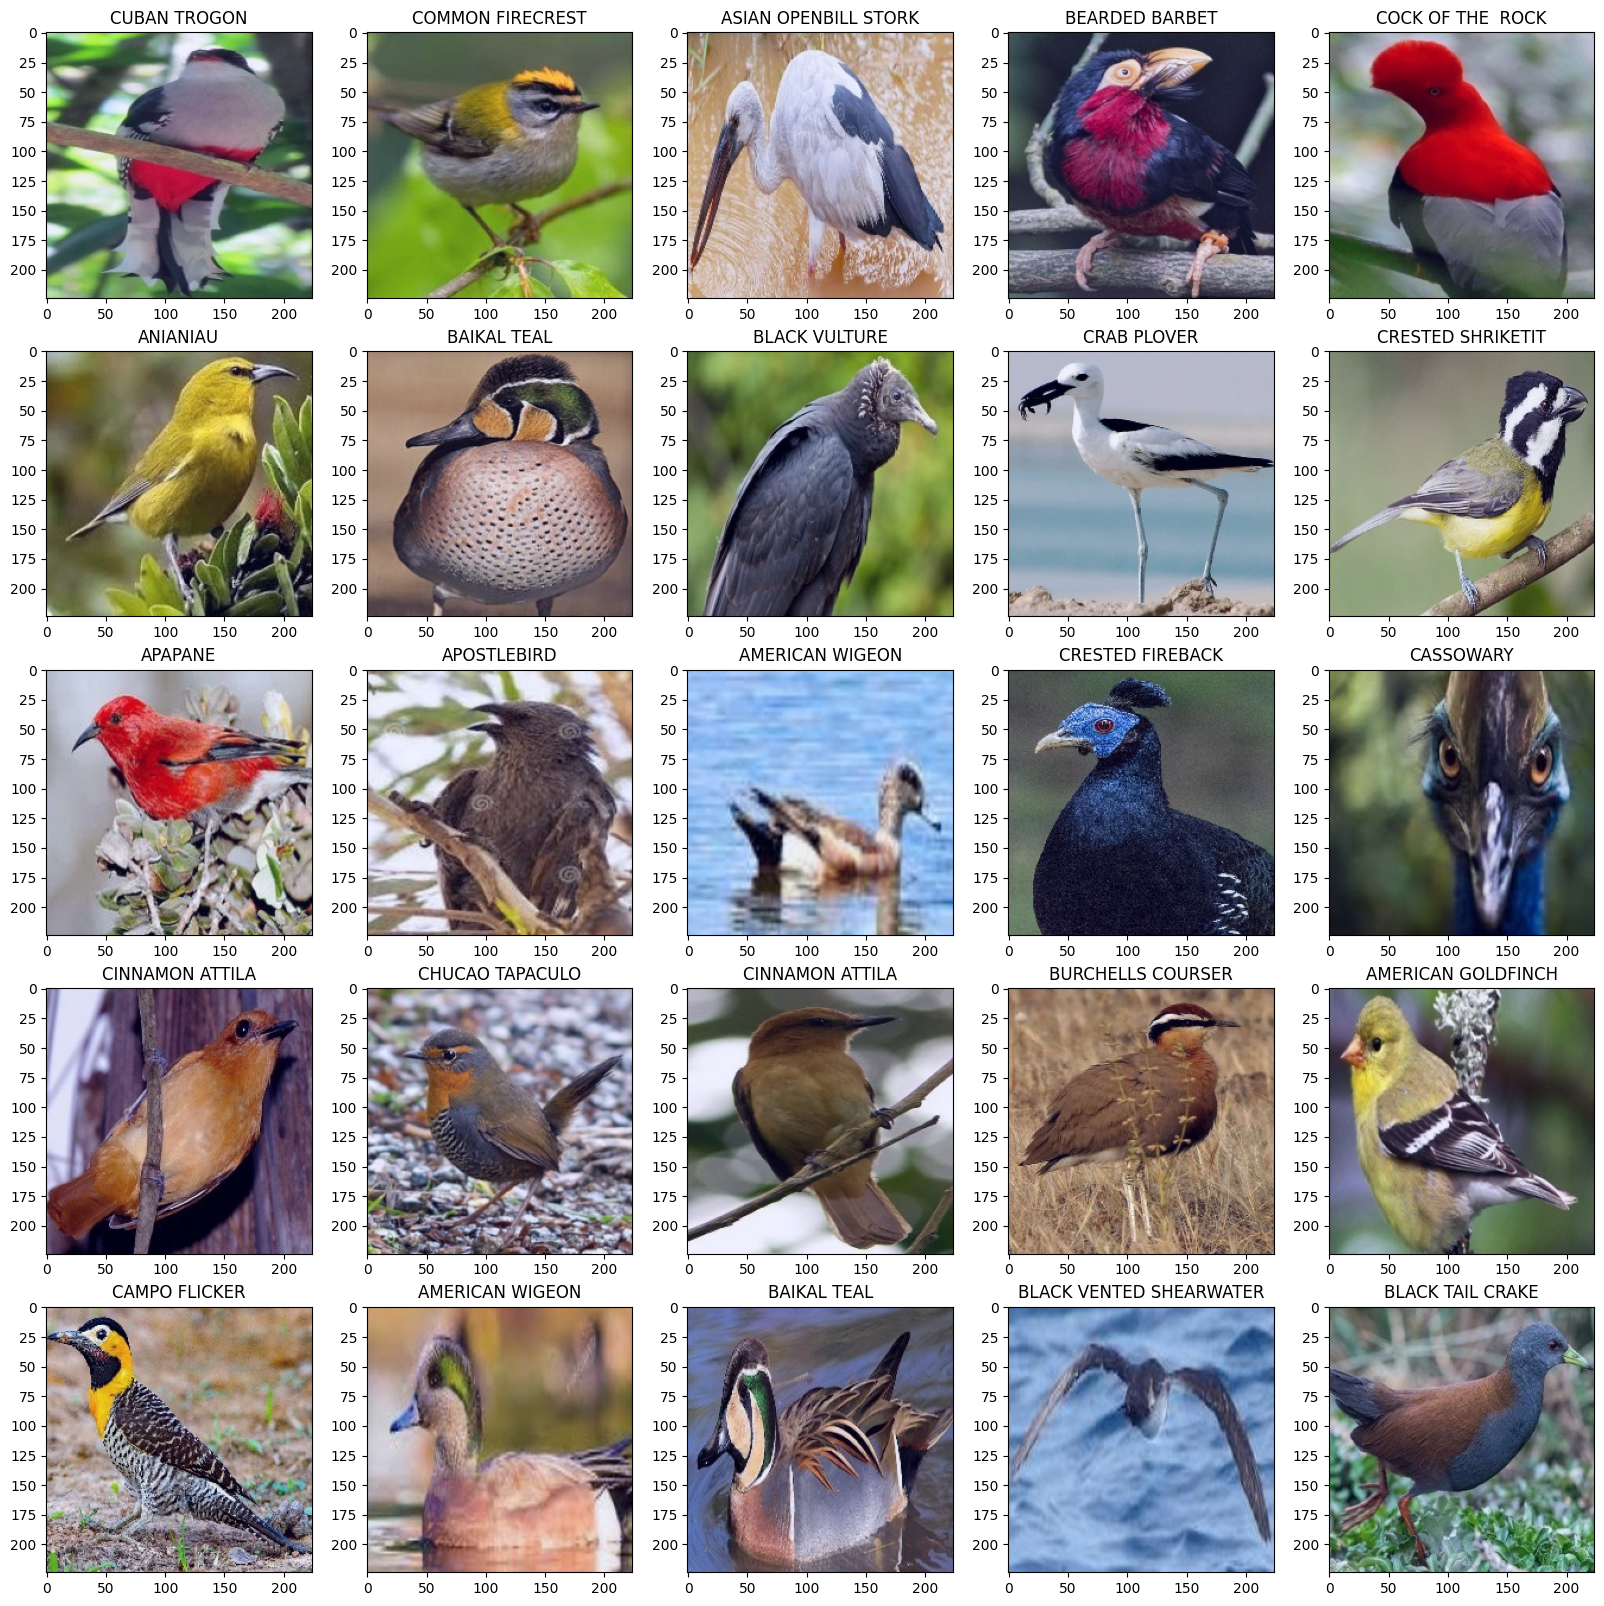

In [9]:
# Visualize some images
# Note: images[i] is a torch tensor in format [Channels, Height, Width] and needs to be changed to [Height, Width, Channels] 
for images, labels in train_loader:
  fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20,20))

  for i, ax in enumerate(axes.flatten()):
    # This swaps the format to [Height, Width, Channels] for visualizing
    img = images[i].permute(1,2,0)
    # Change our standardization into minmax normalization for original colors
    img = (img - img.min()) / (img.max() - img.min())

    ax.imshow(img)
    
    # Here we get the class id with labels[i].item()
    # Then we map that id into the corresponding label using birds_dict
    ax.set_title(birds_dict[labels[i].item()])

  plt.show()
  break


### Model and training

In [32]:
# CUDA is a parallel computing platform and programming model invented by NVIDIA
# It enables great computing performance increases for GPUs
# Requires a compatible GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [34]:
# Allows CUDA Deep Neural Network benchmark mode which could lead to faster runtimes.
torch.backends.cudnn.benchmark = True
# Pretrained EfficientNet-B4 model (Best of both worlds in terms of size and performance [B0-B7])
model = models.efficientnet_b4(weights=True)
# Freeze the pretrained layers from training
for param in model.parameters():
    param.requires_grad = False
# How many inputs the pretrained classifier had in the first linear layer
# model.classifier[0] was a Dropout layer
# model.classifier[1] is a linear layer with 1792 inputs -> n_inputs = 1792
n_inputs = model.classifier[1].in_features
# Our classifier: Linear layer -> ReLU activation -> 20% Dropout -> Linear output layer with 184 outputs
model.classifier = nn.Sequential(
    nn.Linear(n_inputs,2048),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(2048, len(birds_dict))
)
# Move the model to our computing device (GPU/CUDA)
model = model.to(device)
# Print our classification layers
print(model.classifier)

Sequential(
  (0): Linear(in_features=1792, out_features=2048, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=2048, out_features=184, bias=True)
)


In [35]:
# CrossEntropyLoss a staple when it comes to classification
loss_fn = nn.CrossEntropyLoss()
# Adam optimizer another staple. Not too complicated and usually good performance
# Learning rate of 1e-3 is pretty common
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

Actual training and validation loops

In [36]:
# Initialize lists for training and validation accuracies and losses for plotting afterwards
train_losses, train_accs = [], []
val_losses, val_accs = [], []

# Use these to compare latest val_loss and val_acc for improvement
# Set these so that first model will basically always perform better ^
best_val_loss = 100
best_val_acc = 0

# Epochs = 10, tune if necessary
epochs = 10

# Main Loop
for epoch in range(epochs):
  epoch_loss = 0
  epoch_acc = 0
  total = len(train_loader.dataset)
  
  # Training Loop
  
  # Set model to training mode
  model.train()
  for batch, (X, y) in enumerate(train_loader):
    X, y = X.to(device), y.to(device)
    
    # Forward Pass
    predictions = model(X)
    loss = loss_fn(predictions, y)
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    # Accuracy and Loss
    
    # Torch.max() returns the class id with the highest prediction [0-1] for each image
    _, pred_classes = torch.max(predictions.data, dim=1)
    epoch_acc += (pred_classes == y).sum().item()
    epoch_loss += loss.item()
  
  # Training averages for the epoch
  train_loss = epoch_loss / len(train_loader)
  train_losses.append(train_loss)
  train_acc = epoch_acc / total
  train_accs.append(train_acc)
  print(f"Epoch {epoch + 1}: \nTraining Loss: {train_loss:.3f}\nTraining Accuracy: {train_acc:.3f}")
  
  # Validation Loop
  
  # Set model to evaluation mode
  model.eval()
  with torch.no_grad():
    val_epoch_loss = 0
    val_epoch_acc = 0
    val_total = len(validation_loader.dataset)
    
    for batch, (X, y) in enumerate(validation_loader):
      X, y = X.to(device), y.to(device)
      
      # Forward pass like before
      predictions = model(X)
      loss = loss_fn(predictions, y)
      
      # Compute validation metrics like before
      _, pred_classes = torch.max(predictions.data, dim=1)
      val_epoch_acc += (pred_classes == y).sum().item()
      val_epoch_loss += loss.item()
    
    # Validation averages for the epoch
    val_loss = val_epoch_loss / len(validation_loader)
    val_acc = val_epoch_acc / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Validation Loss: {val_loss:.3f}\nValidation Accuracy: {val_acc:.3f}\n")
    
    # Save the model if validation accuracy improved
    # Important step because we don't necessarily want the last model
    # Training accuracy tends to increase the longer we train and leads to overfitting
    # But validation accuracy is a better estimator for our generalization performance
    
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      best_val_acc = val_acc
      torch.save(model.state_dict(), './best_model.pth')
      
print("---------------------------------------------------\n")
print(f"Training complete with:\nBest Validation Loss: {best_val_loss:.3f}\nBest Validation Accuracy: {best_val_acc:.3f}")
    
    
     
  

Epoch 1: 
Training Loss: 1.584
Training Accuracy: 0.637
Validation Loss: 0.539
Validation Accuracy: 0.867

Epoch 2: 
Training Loss: 0.591
Training Accuracy: 0.839
Validation Loss: 0.400
Validation Accuracy: 0.890

Epoch 3: 
Training Loss: 0.410
Training Accuracy: 0.882
Validation Loss: 0.362
Validation Accuracy: 0.898

Epoch 4: 
Training Loss: 0.328
Training Accuracy: 0.905
Validation Loss: 0.354
Validation Accuracy: 0.909

Epoch 5: 
Training Loss: 0.265
Training Accuracy: 0.920
Validation Loss: 0.347
Validation Accuracy: 0.902

Epoch 6: 
Training Loss: 0.221
Training Accuracy: 0.934
Validation Loss: 0.297
Validation Accuracy: 0.904

Epoch 7: 
Training Loss: 0.192
Training Accuracy: 0.943
Validation Loss: 0.320
Validation Accuracy: 0.905

Epoch 8: 
Training Loss: 0.162
Training Accuracy: 0.949
Validation Loss: 0.310
Validation Accuracy: 0.910

Epoch 9: 
Training Loss: 0.144
Training Accuracy: 0.955
Validation Loss: 0.310
Validation Accuracy: 0.911

Epoch 10: 
Training Loss: 0.139
Train

### Plotting learning curves

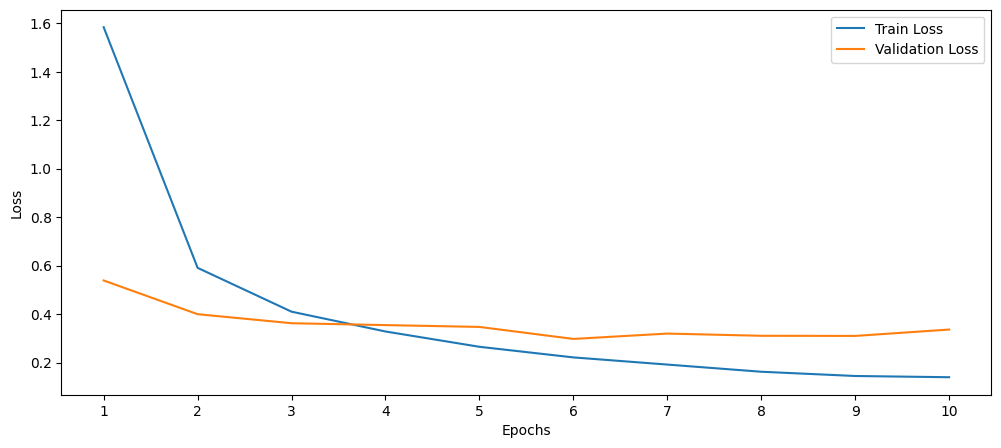

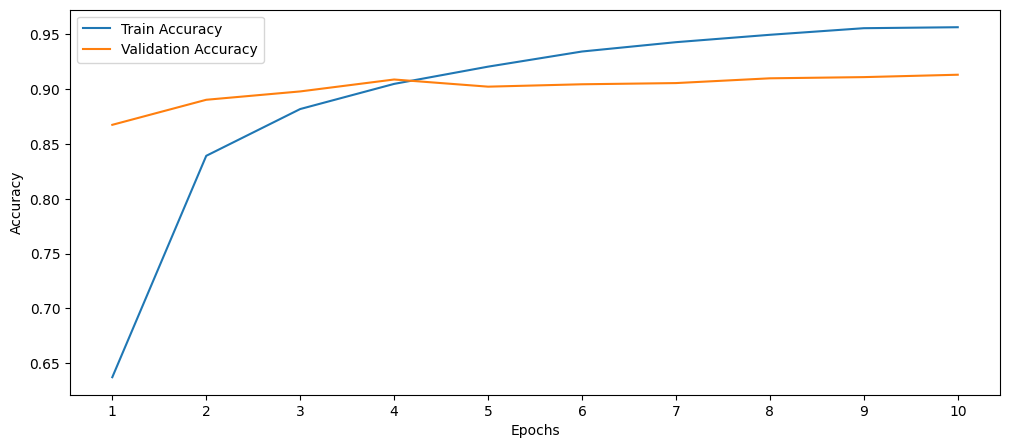

In [37]:
# Loss curves

plt.figure(figsize=(12,5))

plt.plot(train_losses, label = "Train Loss")
plt.plot(val_losses, label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Ticks and labels for those ticks
plt.xticks(ticks = np.arange(len(train_losses)), labels = np.arange(len(train_losses)) + 1)

plt.legend()
plt.show()

# Accuracy curves

plt.figure(figsize=(12,5))

plt.plot(train_accs, label = "Train Accuracy")
plt.plot(val_accs, label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.xticks(ticks = np.arange(len(train_losses)), labels = np.arange(len(train_losses)) + 1)

plt.legend()
plt.show()

### Final Testing

In [40]:
# Similar approach as in validation phase in our training
# Set model to evaluation mode -> Forward pass X -> Compare predictions to labels -> Calculate accuracy
model.eval()
with torch.no_grad():
  test_acc = 0
  test_total = len(test_loader.dataset)
    
  for batch, (X, y) in enumerate(test_loader):
    X, y = X.to(device), y.to(device)
    
    # Forward pass like before
    predictions = model(X)
    
    # Sum correct predictions
    _, pred_classes = torch.max(predictions.data, dim=1)
    test_acc += (pred_classes == y).sum().item()
    
  # Validation averages for the epoch
  final_test_acc = test_acc / test_total
  print(f"Final Test Accuracy: {100*final_test_acc:.1f}%")

Final Test Accuracy: 92.6%
